<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multiple_Time_Series_using_Apache_Spark_and_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [ ]:
!java -version

openjdk version "1.8.0_265"
OpenJDK Runtime Environment (build 1.8.0_265-8u265-b01-0ubuntu2~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.265-b01, mixed mode)


In [ ]:
!pip install pyspark

In [ ]:
!pip install pyarrow==0.15.1

In [ ]:
!pip install fbprophet

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')

In [ ]:
df

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      500 non-null    datetime64[ns]
 1   store_id  500 non-null    int64         
 2   sales     500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [ ]:
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().any())
print ("\nUnique values :  \n",df.nunique())


Features : 
 ['date', 'store_id', 'sales']

Missing values :   date        False
store_id    False
sales       False
dtype: bool

Unique values :  
 date         50
store_id     10
sales       500
dtype: int64


In [ ]:
df

,date,store_id,sales
0,2019-01-06,25,736657.2267
1,2019-01-06,26,233711.0000
2,2019-01-06,28,692156.3794
3,2019-01-06,29,213706.8000
4,2019-01-06,30,266455.0000
...,...,...,...
495,2019-12-15,31,401803.3590
496,2019-12-15,35,135799.1429
497,2019-12-15,38,115424.2250
498,2019-12-15,41,103375.0000


In [ ]:
df_base = df.copy()

In [ ]:
df.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [ ]:
df['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [ ]:
item_df = df.set_index('date')

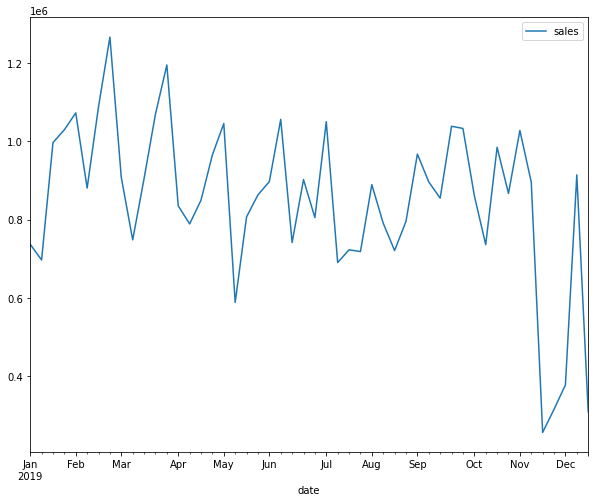

In [ ]:
item_df.query("store_id==25")[['sales']].plot()

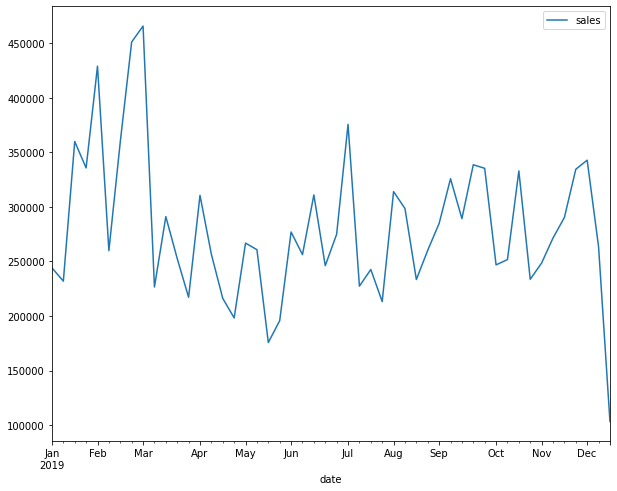

In [ ]:
item_df.query("store_id==41")[['sales']].plot()

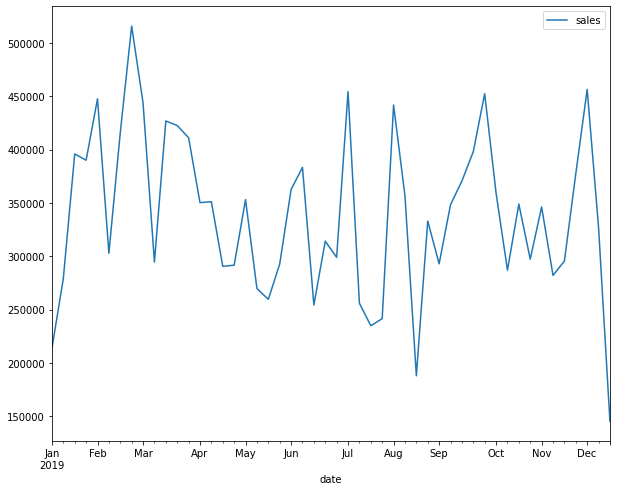

In [ ]:
item_df.query("store_id==29")[['sales']].plot()

In [ ]:
sdf = spark.createDataFrame(df)

In [ ]:
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [ ]:
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [ ]:
sdf.count()

500

In [ ]:
sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [ ]:
sdf.createOrReplaceTempView("sales")

In [ ]:
spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [ ]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [ ]:
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [ ]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [ ]:
sdf.rdd.getNumPartitions()

1

In [ ]:
store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [ ]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [ ]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#89, y#90]
   +- InMemoryRelation [store_id#1L, ds#89, y#90], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#89 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#89 ASC NULLS FIRST, 200), true, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), true, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [ ]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=5, 
    freq='w'
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [ ]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [ ]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [ ]:
results.show()

+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818| 944480.6029893884|467182.13673786196|   2020-10-05|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 968546.0761571078| 507214.0410627372|   2020-10-05|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1195913.7193216942| 751223.3781404383|   2020-10-05|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566|1264510.1371869135| 814019.3817865176|   2020-10-05|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249|1203554.5467683827| 750447.3437600036|   2020-10-05|
|2019-02-10 00:00:00|      25|  

In [ ]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#165, store_id#166, y#167, yhat#168, yhat_upper#169, yhat_lower#170, training_date#177]
   +- InMemoryRelation [ds#165, store_id#166, y#167, yhat#168, yhat_upper#169, yhat_lower#170, training_date#177], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#165, store_id#166, y#167, yhat#168, yhat_upper#169, yhat_lower#170, 18540 AS training_date#177]
            +- FlatMapGroupsInPandas [store_id#1L], forecast_sales(store_id#1L, ds#89, y#90), [ds#165, store_id#166, y#167, yhat#168, yhat_upper#169, yhat_lower#170]
               +- *(1) Sort [store_id#1L ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [store_id#1L, store_id#1L, ds#89, y#90]
                        +- InMemoryRelation [store_id#1L, ds#89, y#90], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
                                 +- *(3) Sort [

In [ ]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [ ]:
results.count()

550

In [ ]:
results.createOrReplaceTempView('forecasted')

In [ ]:
spark.sql("select store_id, count(*) from forecasted group by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [ ]:
final_df = results.toPandas()

In [ ]:
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.444806e+05,467182.136738,2020-10-05
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.685461e+05,507214.041063,2020-10-05
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.195914e+06,751223.378140,2020-10-05
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.264510e+06,814019.381787,2020-10-05
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.203555e+06,750447.343760,2020-10-05
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.265256e+05,1975.031870,2020-10-05
546,2019-12-29,44,NaN,2.657442e+04,8.798489e+04,-39215.240854,2020-10-05
547,2020-01-05,44,NaN,8.801264e+03,6.625828e+04,-51571.877293,2020-10-05
548,2020-01-12,44,NaN,4.665900e+03,6.608215e+04,-54764.840468,2020-10-05


In [ ]:
final_df=final_df.set_index('ds')

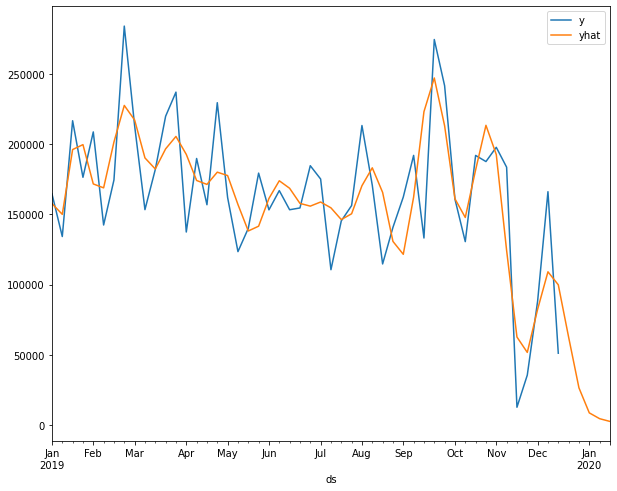

In [ ]:
final_df.query('store_id==44')[['y','yhat']].plot()

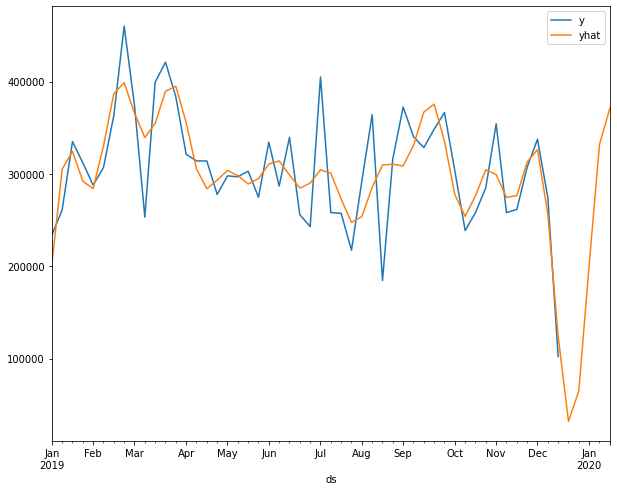

In [ ]:
final_df.query('store_id==26')[['y','yhat']].plot()

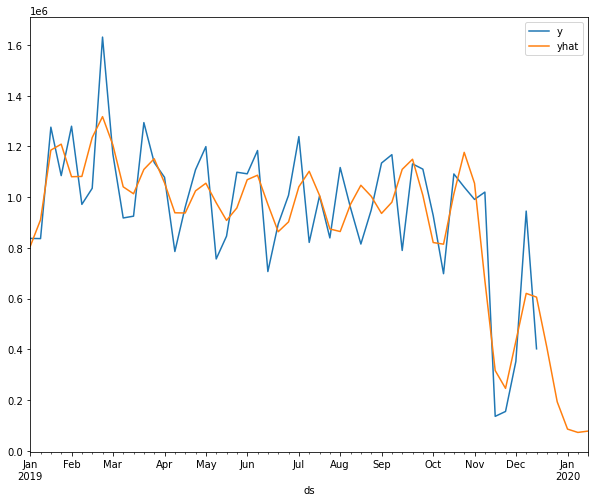

In [ ]:
final_df.query('store_id==31')[['y','yhat']].plot()